# Simulation d’une loi normale

## Rappels sur la loi normale

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numba import njit, vectorize
from math import gamma


@njit
def G(x):
    return gamma(x)


_ = G(1)

In [2]:
@njit
def f_normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)


@njit
def p(size):
    return np.linspace(-size, size, 100)


def test_normal(call, custom_n=10_000, custom_f=f_normal, custom_size=3, custom_bins=50):
    _x = p(custom_size)
    plt.hist(call(custom_n), bins=custom_bins, density=True)
    plt.title(call.__name__)
    plt.plot(_x, custom_f(_x))
    plt.show()

_ = f_normal(1)
_ = p(1)

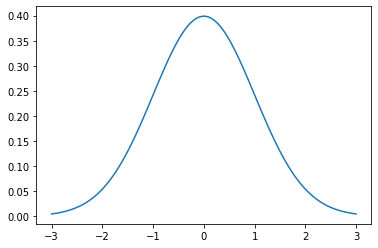

In [3]:
plt.plot(p(3), f_normal(p(3)))
plt.show()

## Méthode de Box-Müller

In [4]:
@njit
def box_muller1(n):
    u1 = np.random.random(n)
    u2 = np.random.random(n)
    return np.sqrt(-2*np.log(u1)) * np.cos(2*np.pi*u2)


@njit
def box_muller2(n):
    u1 = np.random.random(n)
    u2 = np.random.random(n)
    return np.sqrt(-2*np.log(u1)) * np.sin(2*np.pi*u2)

_ = box_muller1(1)
_ = box_muller2(1)

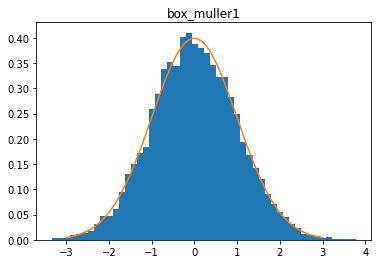

In [5]:
test_normal(box_muller1)

In [6]:
test_normal(box_muller2)

## Méthode de rejet via la loi de Laplace

In [7]:
def identity(x: np.float64) -> np.float64:
    return x

@njit
def meth_rejet(f, g, create_y, theta, n):
    res = np.zeros(n)
    
    for i in range(n):
        while True:
            y = create_y()
            u = np.random.random()
            if f(y) > theta * u * g(y):
                break
        res[i] = y
    return res


_ = meth_rejet(njit(identity), njit(identity), njit(lambda : 1), 1, 1)

In [8]:
@njit
def f_laplace(x):
    return np.exp(-np.abs(x))/2


@njit
def laplace(n):
    u = np.random.random(n)
    return -np.sign(u-1/2)*np.log(1-2*np.abs(u - 1/2))


_ = f_laplace(1)
_ = laplace(1)

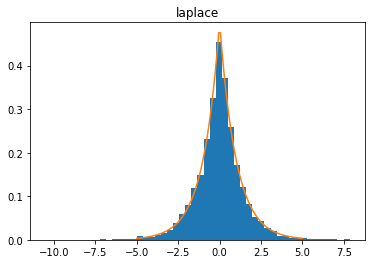

In [9]:
test_normal(laplace, custom_f=f_laplace, custom_size=5)

In [10]:
@njit
def rejet(n):
    def tmp():
        return laplace(1)[0]
    return meth_rejet(f_normal, f_laplace, tmp, np.sqrt(2*np.e/np.pi), n)

_ = rejet(1)

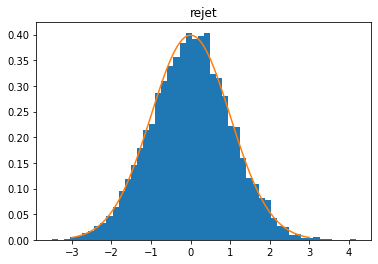

In [11]:
test_normal(rejet)

# Lois dérivées de la loi normale

## Loi du Khi-deux

In [12]:
@njit
def f_khi2(x, _n):
    return (x**(_n/2-1) * np.exp(-x/2)) / (G(_n/2) * 2**(_n/2))


@njit
def khi2(n, _n):
    return np.sum(box_muller1((n, _n))**2, axis=1)


_ = f_khi2(1, 1)
_ = khi2(1, 1)

In [13]:
@njit
def f_khi2_5(x):
    return f_khi2(x, 5)


@njit
def khi2_5(n):
    return khi2(n, 5)


_ = f_khi2_5(1)
_ = khi2_5(1)

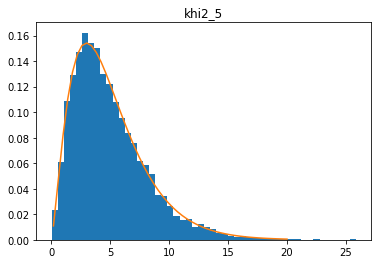

In [14]:
test_normal(khi2_5, custom_f=f_khi2_5, custom_size=20)

## Loi de Student

In [15]:
@njit
def f_student(x, _n):
    return G((_n+1)/2) / (G(_n/2) * np.sqrt(np.pi*_n) * (1+x**2/_n)**((_n+1)/2))


@njit
def student(n, _n):
    return box_muller1(n)/np.sqrt(khi2(n, _n)/_n)


_ = f_student(1, 1)
_ = student(1, 1)

In [16]:
@njit
def f_student_5(x):
    return f_student(x, 5)


@njit
def student_5(n):
    return student(n, 5)


_ = f_student_5(1)
_ = student_5(1)

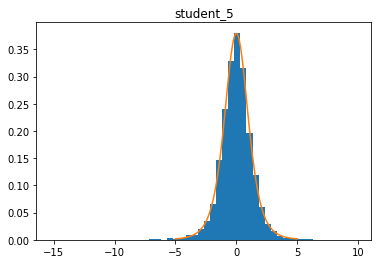

In [17]:
test_normal(student_5, custom_f=f_student_5, custom_size=5)

## Un résultat remarquable

In [18]:
@njit
def normal_3_2_6():
    """
    On notera que si X suit une loi N(0; 1), alors Y := σX + m suit une loi N(m;σ²).
    """
    return np.sqrt(2)*box_muller1(6) + 3

_ = normal_3_2_6()

In [19]:
@njit
def Z_n(n):
    r = np.zeros(n)
    for i in range(n):
        rand = normal_3_2_6()
        s_n_2 = np.sum((rand - rand.mean())**2)
        r[i] = s_n_2/2
    return r

_ = Z_n(1)

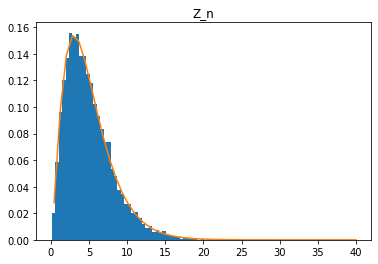

In [20]:
test_normal(Z_n, custom_f=f_khi2_5, custom_size=40)

In [21]:
@njit
def T_n(n):
    r = np.zeros(n)
    for i in range(n):
        rand = normal_3_2_6()
        s_n_2 = np.sum((rand - rand.mean())**2)/5
        r[i] = np.sqrt(6)*(rand.mean()-3)/np.sqrt(s_n_2)
    return r

_ = T_n(1)

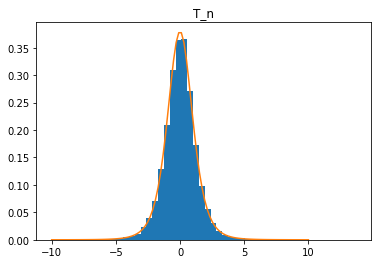

In [22]:
test_normal(T_n, custom_f=f_student_5, custom_size=10)

# Approximation d’une loi normale

## Lien avec la loi binomiale

In [23]:
@njit
def B(N, n, p):
    return (np.random.binomial(n=n, p=p, size=N)-n*p)/np.sqrt(n*p*(1-p))

_ = B(1,1,1)

In [24]:
test_normal(lambda n: B(n, 10_000, 0.5))

In [25]:
test_normal(lambda n: B(n, 10_000, 0.2))

La planche de Galton est la meme experience de parametres $p=0.5$ et $n=$[Nb de lignes].

## Lien avec la loi de Poisson

In [26]:
@njit
def E(l):
    return np.random.exponential(1/l)

_ = E(1)

In [27]:
@njit
def P(n, l):
    res = np.zeros(n)
    for i in range(n):
        r = -1
        s = 0
        while s < 1:
            s += E(l)
            r += 1
        res[i] = r
    return res

_ = P(1, 1)

L = 1


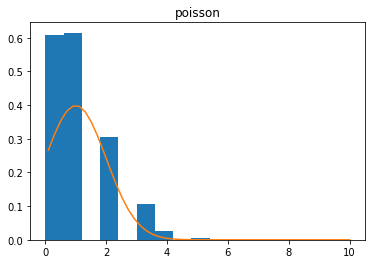

L = 2


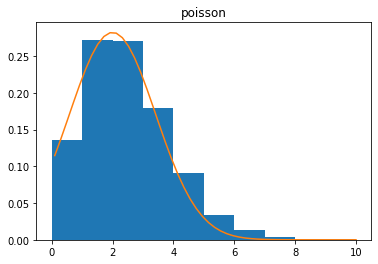

L = 3


L = 4


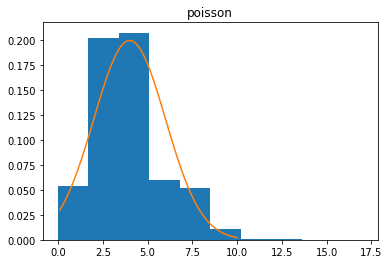

In [28]:
for L in range(1, 5):
    print(f'L = {L}')
    
    def poisson(n):
        return P(n, L)

    @vectorize
    def N_L_L(x):
        if x >= 0:
            return np.exp(-(x-L)**2/(2*L))/np.sqrt(L*2*np.pi)
        return np.nan

    test_normal(poisson, custom_f=N_L_L, custom_size=10, custom_bins=None)

## Lien avec la loi de Student

In [29]:
@njit
def student_1000(n):
    return student(n, 1000)


_ = student_1000(1)

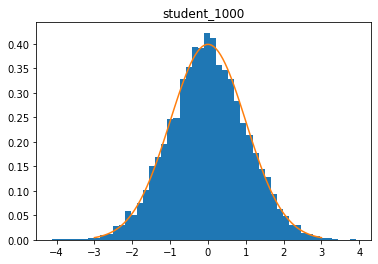

In [30]:
test_normal(student_1000, custom_f=f_normal)

Ce qui est normal car qand $n$ est grand on a :
$$
    f_n(x) = 
    \frac{\Gamma((n+1)/2)}{\Gamma(n/2)} \times
    \frac{1}{\sqrt{n\pi}} \times
    \frac{1}{(1+\frac{x^2}{n})^{\frac{n+1}{2}}} \\
    \sim
    (\frac{\frac{n + 1}{2}}{e})^\frac{n + 1}{2} \times 
    (\frac{e}{\frac{n}{2}})^\frac{n}{2} \times 
    \frac{e^{-\frac{n+1}{2}ln(1+\frac{x^2}{n})}}{\sqrt{n\pi}} \\
    \sim
    Exp[\frac{n + 1}{2}(ln(\frac{n + 1}{2}) - 1) - \frac{n}{2}(ln(\frac{n}{2}) - 1)] \times
    \frac{e^{-\frac{n}{2}\times \frac{x^2}{n}}}{\sqrt{n\pi}} \\
    \sim
    Exp[\frac{n}{2}(ln(\frac{n+1}{2}) - ln(\frac{n}{2})) + (ln(\frac{n+1}{2}) - 1)/2] \times
    \frac{e^{-\frac{x^2}{2}}}{\sqrt{n\pi}} \\
    \sim
    Exp[\frac{ln(n/2)}{2}] \times \frac{e^{-\frac{x^2}{2}}}{\sqrt{n\pi}} \\
    \sim
    \sqrt{\frac{n}{2}} \times \frac{e^{-\frac{x^2}{2}}}{\sqrt{n\pi}} \\
    \sim
    \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}} \\
$$
Qui est exactement $\mathcal{N}(0,1)$. Il n'est donc pas étonant d'obtenir le résultat précédent.

## TCL

In [31]:
def TCL(loi, n, custom_n=10_000, custom_size=3, custom_bins=50):
    """
    Test le TCL pour la loi `loi` (assuming loi get size parameter)
    """
    # get m and o :
    m = loi(size=1_000_000).mean()
    o = loi(size=1_000_000).std()
    
    def Y(_n):
        return np.sqrt(n)/o * (loi(size=(n, _n)).mean(axis=0) - m)
    
    Y.__name__ += "_" + loi.__name__
    
    test_normal(Y, custom_n=custom_n, custom_size=custom_size, custom_bins=custom_bins)

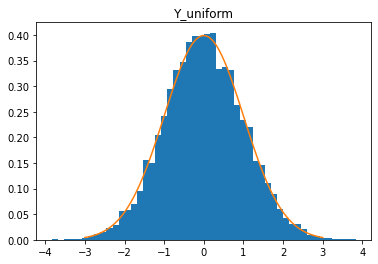

In [32]:
TCL(np.random.uniform, 100)

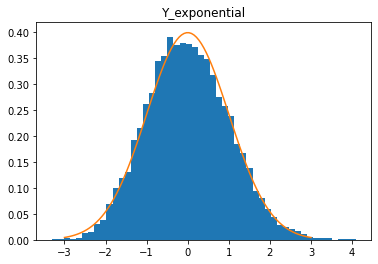

In [33]:
TCL(np.random.exponential, 100)

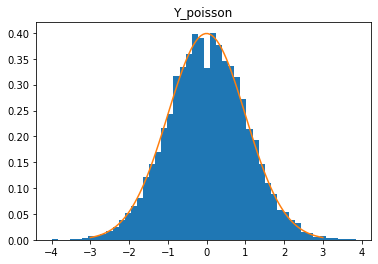

In [34]:
TCL(np.random.poisson, 1000)

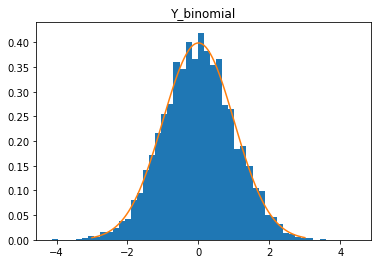

In [35]:
def binomial(size):
    """
    nimporte quelle fonction custom qui rend une matrice numpy de variables indépendentes de meme loi
    """
    return np.random.binomial(100, 0.5, size=size)

TCL(binomial, 100)